In [0]:
print ("Number of train files:",len(os.listdir("../input/train")))
print ("Number of test files:",len(os.listdir("../input/test")))

dftrain=pd.read_csv("../input/train_labels.csv",dtype=str)
dftrain.head()

Number of train files: 220025
Number of test files: 57458


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
print("Counts of negative and postive labels in training data:")
dftrain.groupby(['label']).count()

Counts of negative and postive labels in training data:


,id
label,
0,130908
1,89117


In [0]:
# Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from keras.callbacks import Callback
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve,auc, confusion_matrix

Using TensorFlow backend.


In [0]:
def add_ext(id):
    return id+".tif"

dftrain["id"]=dftrain["id"].apply(add_ext)

def addpath(col):
    return '../input/train/' + col 

dftrain['Path']=dftrain['id'].apply(addpath)
dftrain.head()

,id,label,Path
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0,../input/train/f38a6374c348f90b587e046aac60799...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,../input/train/c18f2d887b7ae4f6742ee445113fa1a...
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0,../input/train/755db6279dae599ebb4d39a9123cce4...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0,../input/train/bc3f0c64fb968ff4a8bd33af6971eca...
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0,../input/train/068aba587a4950175d04c680d38943f...


In [0]:
## function to plot historgrams

def plothist(plot_img,axnum):
    color = ('b','g','r')
    for j,col in enumerate(color):
         histr = cv2.calcHist([plot_img],[j],None,[256],[0,256])
         ax[axnum,i].plot(histr,color = col)
         ax[axnum,i].set_xlim([0,256])
         ax[axnum,i].set_xlabel("Pixel Values")
         ax[axnum,0].set_ylabel("# of Pixels")
    return 

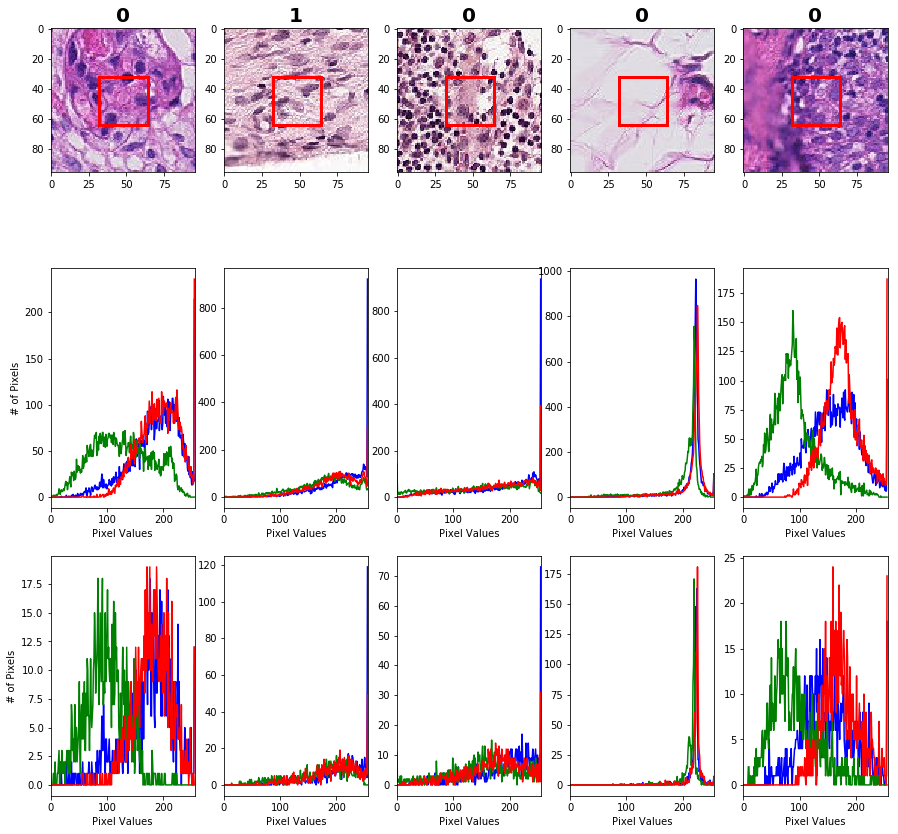

In [0]:
## print a sample of the images
nums = [76, 46, 69, 20, 17] # random.sample(range(1, 100), 5)
num_pics = len(nums)
f,ax = plt.subplots(3,num_pics,figsize=(15,15))

for i in range(5):
    img = plt.imread(dftrain.iloc[nums[i]]['Path'])
   # ax[i].imshow(img)
   # ax[i].set_title(dfdata.iloc[i]['label'],fontweight="bold", size=20)
    ax[0,i].imshow(img)
    ax[0,i].set_title(dftrain.iloc[i]['label'],fontweight="bold", size=20)
    # Create a Rectangle patch
    rect = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax[0,i].add_patch(rect)
    ## plot histograms of full image and cancer patch
    plothist(img,1)
    plothist(img[32:64, 32:64],2)
    
plt.show() 

In [0]:
## use flow from directory
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [0]:
batch_size = 20
image_size = (96,96)

train_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode='categorical', #class_mode="binary",
target_size=image_size)

validation_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode='categorical', #class_mode="binary",
target_size=image_size)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "sigmoid"))

model.summary()

model.compile('Adam', loss = "binary_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               17334528  
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
__________

In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "sigmoid"))

model.summary()

model.compile(Adam(0.0001), loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 41, 41, 64)        36928     
__________

In [0]:
trainstep=train_generator.n//train_generator.batch_size
valstep=validation_generator.n//validation_generator.batch_size

filepath="weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=trainstep,
                    validation_data=validation_generator,
                    validation_steps=valstep,
                    epochs=20,
                    callbacks=[checkpoint]
)

Epoch 1/20
8801/8801 [==============================] - 633s 72ms/step - loss: 0.4229 - acc: 0.8100 - val_loss: 0.4448 - val_acc: 0.8126

Epoch 00001: val_acc improved from -inf to 0.81261, saving model to weights-best.hdf5
Epoch 2/20
8801/8801 [==============================] - 239s 27ms/step - loss: 0.3302 - acc: 0.8589 - val_loss: 0.3587 - val_acc: 0.8435

Epoch 00002: val_acc improved from 0.81261 to 0.84354, saving model to weights-best.hdf5
Epoch 3/20
8801/8801 [==============================] - 235s 27ms/step - loss: 0.2840 - acc: 0.8820 - val_loss: 0.2578 - val_acc: 0.8906

Epoch 00003: val_acc improved from 0.84354 to 0.89058, saving model to weights-best.hdf5
Epoch 4/20
8801/8801 [==============================] - 236s 27ms/step - loss: 0.2565 - acc: 0.8959 - val_loss: 0.2417 - val_acc: 0.9031

Epoch 00004: val_acc improved from 0.89058 to 0.90310, saving model to weights-best.hdf5
Epoch 5/20
8801/8801 [==============================] - 234s 27ms/step - loss: 0.2384 - acc: 0.

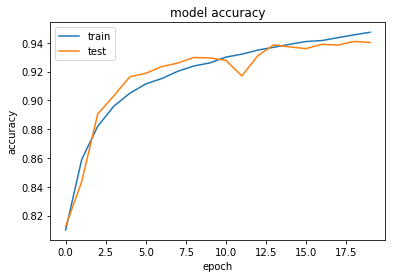

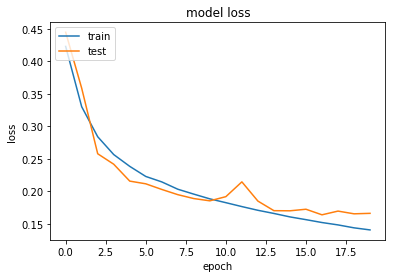

In [0]:
# plot learning curves
filepath="weights-best.hdf5"
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
## Create test generator and evaluate model 

model.load_weights(filepath) #load saved weights
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=datagen.flow_from_dataframe(
dataframe=dftrain,
directory="../input/train/",
x_col="id",
y_col="label",
subset="validation",
batch_size=5,   # want to divide num samples evenly 
seed=42,
shuffle=False,  # don't shuffle
class_mode='categorical', #class_mode="binary",
target_size=image_size)


Found 44005 validated image filenames belonging to 2 classes.


In [0]:
test_labels = test_generator.classes
y_preds = model.predict_generator(test_generator,verbose=1,steps=test_generator.n/5)


8801/8801 [==============================] - 47s 5ms/step


In [0]:
y_pred_keras=np.argmax(y_preds, axis=-1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC score :', + auc_keras)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_keras))

AUC score : 0.9370061467371399
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26233
           1       0.94      0.92      0.93     17772

    accuracy                           0.94     44005
   macro avg       0.94      0.94      0.94     44005
weighted avg       0.94      0.94      0.94     44005



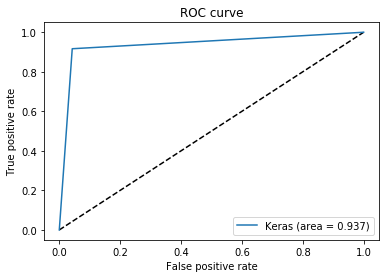

In [0]:
# plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

[[25117  1116]
 [ 1483 16289]]


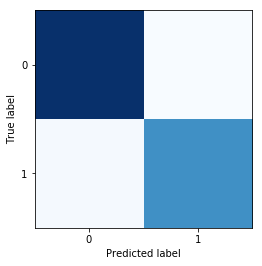

In [0]:
classes=list((test_generator.class_indices).values())
cm=confusion_matrix(test_labels,y_pred_keras)

plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.imshow(cm, cmap=plt.cm.Blues)
print(cm)

In [0]:
len(test_generator.filenames)

44005

In [0]:
test_frame=pd.DataFrame({'id':(test_generator.filenames)})
test_frame['true_label']=test_labels
test_frame['predicted'] = y_pred_keras
test_frame['no_cancer'] = y_preds[:,0]
test_frame['cancer'] = y_preds[:,1]
test_frame['Path']=test_frame['id'].apply(addpath)

In [0]:
incorrect_preds=(test_frame[test_frame.true_label != test_frame.predicted]).head()
no_cancer=incorrect_preds.nlargest(3, columns='no_cancer')
no_cancer

,id,true_label,predicted,no_cancer,cancer,Path
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,0,0.990599,0.009401,../input/train/c18f2d887b7ae4f6742ee445113fa1a...
15,f416de7491a31951f79b3cee75b002f4d1bf0162.tif,0,1,0.314422,0.685578,../input/train/f416de7491a31951f79b3cee75b002f...
41,856624fee163510c5bedc4d3307eae5e17ecd412.tif,0,1,0.307782,0.692218,../input/train/856624fee163510c5bedc4d3307eae5...


In [0]:
cancer=(incorrect_preds.nlargest(3, columns='cancer'))[(incorrect_preds.true_label==0)]
cancer_list=cancer['id'].values.tolist()
cancer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,true_label,predicted,no_cancer,cancer,Path
46,51a9623efcf8ea536a098e0cd80223a0a0f7ce9c.tif,0,1,0.028484,0.971516,../input/train/51a9623efcf8ea536a098e0cd80223a...
38,1ef450ccba59e14358893b0659b9863ec8b1adf2.tif,0,1,0.305638,0.694362,../input/train/1ef450ccba59e14358893b0659b9863...
41,856624fee163510c5bedc4d3307eae5e17ecd412.tif,0,1,0.307782,0.692218,../input/train/856624fee163510c5bedc4d3307eae5...


IndexError: index 2 is out of bounds for axis 0 with size 2

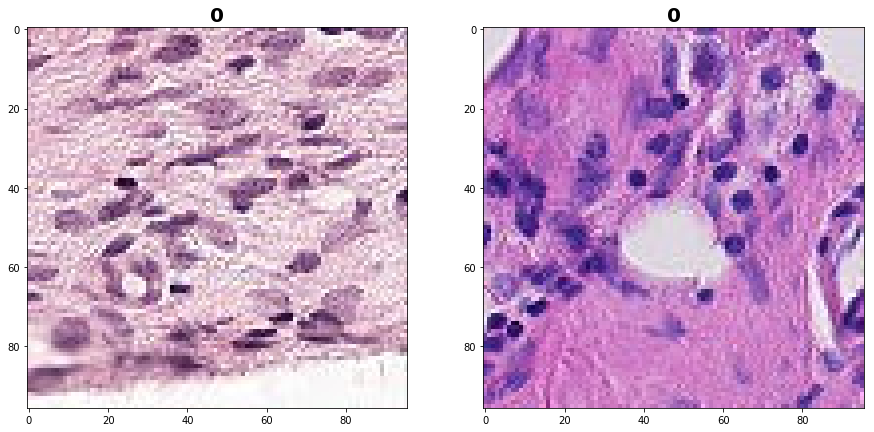

In [0]:
## plot the "most incorrect" images

f,ax = plt.subplots(1,2,figsize=(15,15))

for i in range(len(cancer)):
    img = plt.imread(cancer.iloc[i]['Path'])
    ax[i].imshow(img)
    ax[i].set_title(cancer.iloc[i]['true_label'],fontweight="bold", size=20)  
    
plt.show() 

f,ax = plt.subplots(1,2,figsize=(15,15))

for i in range(2):
    img = plt.imread(no_cancer.iloc[i]['Path'])
    ax[i].imshow(img)
    ax[i].set_title(no_cancer.iloc[i]['true_label'],fontweight="bold", size=20)  


In [0]:
## look at the "most correct" submission
no_cancer_true=test_frame.nlargest(3, columns='no_cancer')
cancer_true=test_frame.nlargest(3, columns='cancer')
no_cancer_true.head()

,id,true_label,predicted,no_cancer,cancer,Path
741,32d9aff1af7ca3ef7c0ca96fd972afc593133521.tif,0,0,1.0,9.533981e-10,../input/train/32d9aff1af7ca3ef7c0ca96fd972afc...
1953,e48f8622dda1de9207ee649d214ff9661d58aaa6.tif,0,0,1.0,4.304928e-08,../input/train/e48f8622dda1de9207ee649d214ff96...
2010,9df00bbc6b78850db8dbb1629ccd63b95af3dcae.tif,0,0,1.0,4.082561e-08,../input/train/9df00bbc6b78850db8dbb1629ccd63b...


In [0]:
cancer_true.head()

,id,true_label,predicted,no_cancer,cancer,Path
708,daaf48d1359dc926faa15b4c6c4b24980c9bb2dd.tif,1,1,4.047229e-09,1.0,../input/train/daaf48d1359dc926faa15b4c6c4b249...
1127,1bc1b5a99db05994ca120ca56acd7a96d6d2312c.tif,1,1,1.751265e-08,1.0,../input/train/1bc1b5a99db05994ca120ca56acd7a9...
1196,dbfcd4191b96da1bc4d4c385543e47648266e57e.tif,1,1,5.305694e-09,1.0,../input/train/dbfcd4191b96da1bc4d4c385543e476...


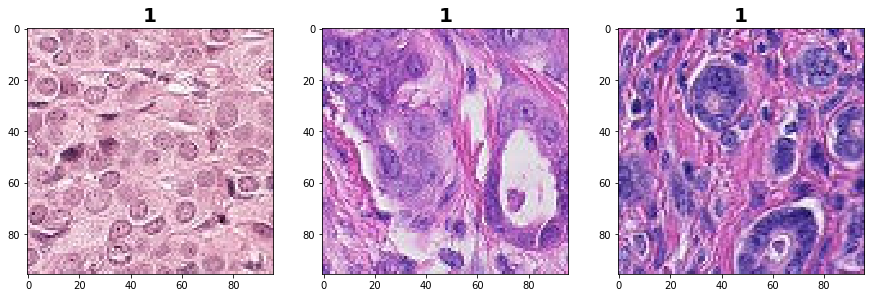

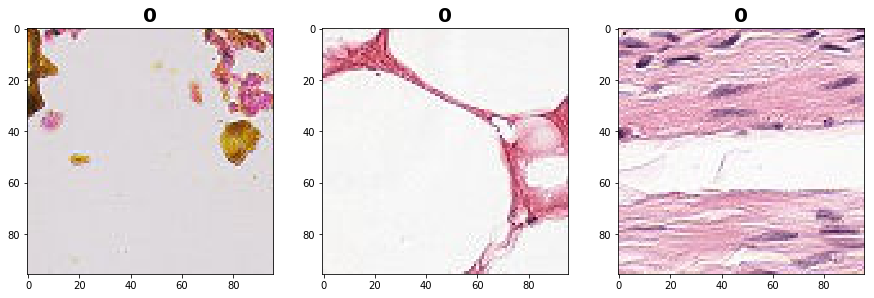

In [0]:
## plot the "most incorrect" images

f,ax = plt.subplots(1,3,figsize=(15,15))

for i in range(3):
    img = plt.imread(cancer_true.iloc[i]['Path'])
    ax[i].imshow(img)
    ax[i].set_title(cancer_true.iloc[i]['true_label'],fontweight="bold", size=20)  
    
plt.show() 

f,ax = plt.subplots(1,3,figsize=(15,15))

for i in range(3):
    img = plt.imread(no_cancer_true.iloc[i]['Path'])
    ax[i].imshow(img)
    ax[i].set_title(no_cancer_true.iloc[i]['true_label'],fontweight="bold", size=20)  


Generate perdictions for submission

In [0]:
test_results=pd.DataFrame({'id':os.listdir("../input/test/")})
test_datagen=ImageDataGenerator(rescale=1./255)

submit_generator=datagen.flow_from_dataframe(
dataframe=test_results,
directory="../input/test/",
x_col="id",
batch_size=2,   # want to divide num samples evenly 
shuffle=False,  # don't shuffle
class_mode=None,
target_size=image_size)

Found 57458 validated image filenames.


In [0]:
## use 0.5 as threshold to assign to class 0 or 1 
y_test_prob=model.predict_generator(submit_generator,verbose=1,steps=submit_generator.n/2)
y_test_pred=np.argmax(y_test_prob, axis=-1)  #y_test_prob.round()

28729/28729 [==============================] - 162s 6ms/step


In [0]:
results = pd.DataFrame({'id':(submit_generator.filenames)})

def remove_ext(id):
    return (id.split('.'))[0]
results['id']=results['id'].apply(remove_ext)

In [0]:
results['label'] = y_test_pred
results.to_csv("submission.csv",index=False)
results.head()

,id,label
0,0eb051700fb6b1bf96188f36c8e4889598c6a157,0
1,c99d6bc4cee9df4c93a0c3f4138664db59e1e6ef,0
2,2859428095a9d1e6aba4bc135c69b59693b6d02a,0
3,13141967dff006e2e3f65282a02d3faf46ec038f,0
4,ad15cf4e12c953fd5822eec528c55a54fccaeae8,1


In [1]:
jupyter nbconvert --to pdf notebook.ipynb

SyntaxError: ignored